In [130]:
import os
os.environ["OMP_NUM_THREADS"] = str(1)


In [131]:
import baccoemu
import chainconsumer
import dynesty
import gc
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count
import tensorflow as tf
import torch

import emcee
import pandas as pd
import time

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import sbi_tools
import plot_utils
#import scripts
# from scripts import sbi_tools
#from scripts import plot_utils
import generate_emuPks as genP

from momentnetworks import demo

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
n_threads = 1
tf.config.threading.set_inter_op_parallelism_threads(n_threads)
tf.config.threading.set_intra_op_parallelism_threads(n_threads)
# note: does NOT work to call sbi_tools.set_N_threads for some reason, need to do it here
#os.environ["OMP_NUM_THREADS"] = str(n_threads)
#os.environ["MKL_NUM_THREADS"] = str(n_threads)
#torch.set_num_threads(n_threads)

In [133]:
run_moment = True
run_emcee = True

In [134]:
plot_dir = '../plots/plots_2024-03-06'
save_plots = False

tag_data = '_gaussian'
tag_fit = ''

In [135]:

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
print(f"Using {n_threads} threads")

48 CPUs
Using 1 threads


In [136]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Load data

In [138]:
rng = np.random.default_rng(seed=533)
n_train = 1000

dict_bounds = {
    'mu1'    :  [1, 2],
    'mu2'    :  [2, 4],
}
param_names = list(dict_bounds.keys())
#n_dim = len(param_names)
n_dim = 5*len(param_names)

theta = []
for param_name in dict_bounds.keys():
    th = rng.uniform(low=dict_bounds[param_name][0], high=dict_bounds[param_name][1], size=n_train)
    theta.append(th)
theta = np.array(theta).T
print(theta.shape)

#theta = np.expand_dims(rng.uniform(size=n_train), axis=1)
#Pk = rng.normal(loc=theta[0], size=(n_dim, n_train)).T

# TODO diff cov for each??
cov = [[0.02, 0.0], 
       [0.0, 0.1]]
# cov = [[0.005, 0.0], 
#        [0.0, 0.01]]

Pk = []
Pk_noiseless = []
for i in range(n_train):
    pk_noiseless = theta[i]
    pk = rng.multivariate_normal(theta[i], cov, size=n_dim).T
    Pk.append(pk)
    Pk_noiseless.append(pk_noiseless)
Pk = np.array(Pk)
Pk_noiseless = np.array(Pk_noiseless)
print(Pk.shape)

(1000, 2)
(1000, 2)


In [139]:
np.min(theta, axis=0), np.max(theta, axis=0), 

(array([1.00051691, 2.00012312]), array([1.99999   , 3.99985568]))

In [140]:
# tag_emuPk = '_2param'

# fn_emuPk = f'../data/emuPks/emuPks{tag_emuPk}.npy'
# fn_emuPk_params = f'../data/emuPks/emuPks_params{tag_emuPk}.txt'
# fn_emuk = f'../data/emuPks/emuPks_k{tag_emuPk}.txt'
# fn_emuPkerrG = f'../data/emuPks/emuPks_errgaussian{tag_emuPk}.npy'

# Pk_noiseless = np.load(fn_emuPk)
# gaussian_error_pk = np.load(fn_emuPkerrG)
# theta = np.genfromtxt(fn_emuPk_params, delimiter=',', names=True)
# param_names = theta.dtype.names
# # from tuples to 2d array
# theta = np.array([list(tup) for tup in theta])
# kk = np.genfromtxt(fn_emuk)

In [141]:
param_label_dict = {'mu1': r'$\mu_1$',
                    'mu2': r'$\mu_2$',
                    }
param_labels = [param_label_dict[param_name] for param_name in param_names]

In [142]:
n_tot = theta.shape[0]
n_params = theta.shape[1]

In [143]:
print(Pk_noiseless.shape, theta.shape)

(1000, 2) (1000, 2)


Plot P(k) data:

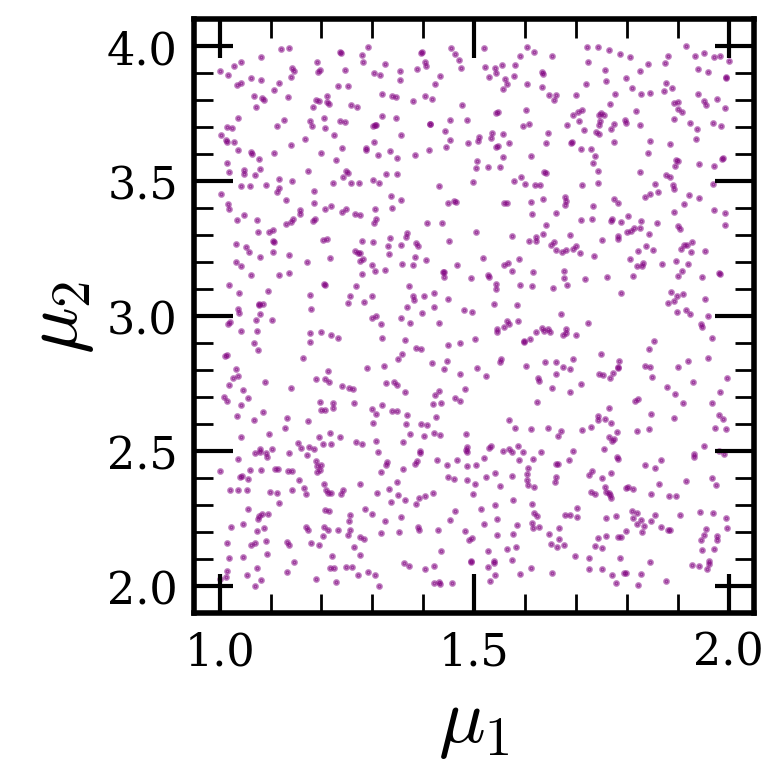

In [144]:
fig, ax = mpl.pyplot.subplots(figsize=(4,4))
ax.scatter(theta[:,0], theta[:,1], s=2, alpha=0.5, color='purple')

ax.set_xlabel(param_label_dict[param_names[0]])
ax.set_ylabel(param_label_dict[param_names[1]])

mpl.pyplot.tight_layout()
mpl.pyplot.show()

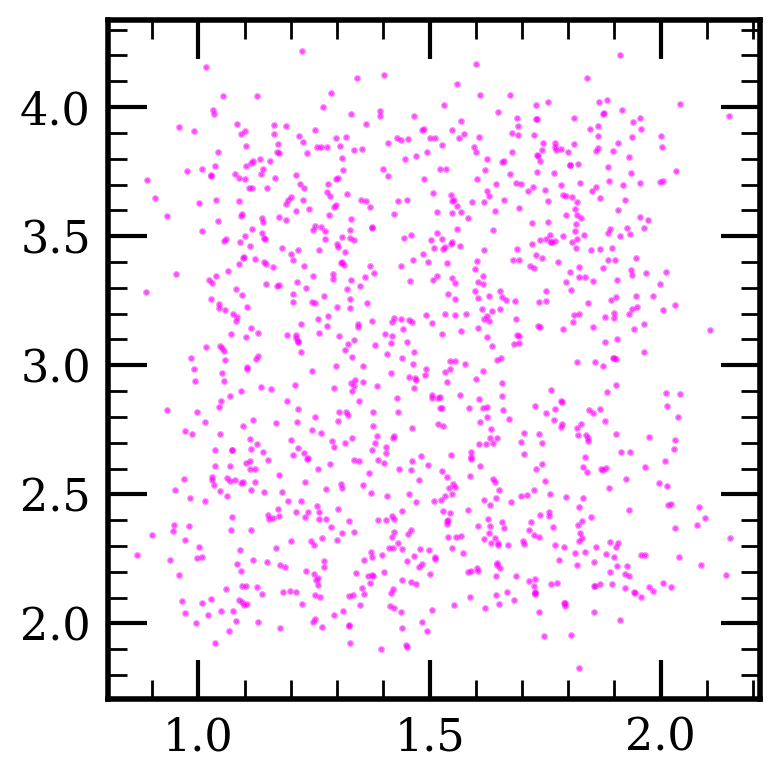

In [145]:
fig, ax = mpl.pyplot.subplots(figsize=(4,4))
ax.scatter(Pk[:,0], Pk[:,1], s=2, alpha=0.5, color='magenta')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [146]:
#n_biasmodels = len(biases_vec)
n_biasmodels = 0
n_cosmos = n_params
print(n_biasmodels, n_cosmos)

0 2


Split into train-val-test

In [147]:
#p_train, p_test = 0.2, 0.75
p_train, p_test = 0.8, 0.1
p_val = 1-p_train-p_test
train_split = int(theta.shape[0]*p_train)
test_split = int(theta.shape[0]*(1-p_test))
#train_val_split = int(n_biasmodels*round(theta.shape[0]*0.99/n_biasmodels))

theta_train = theta[:train_split]
theta_val = theta[train_split:test_split]
theta_test = theta[test_split:]
print(theta_train.shape, theta_val.shape, theta_test.shape)

(800, 2) (100, 2) (100, 2)


In [148]:
Pk_train = Pk[:train_split]
Pk_val = Pk[train_split:test_split]
Pk_test = Pk[test_split:]

Pk_noiseless_train = Pk_noiseless[:train_split]
Pk_noiseless_val = Pk_noiseless[train_split:test_split]
Pk_noiseless_test = Pk_noiseless[test_split:]

# mask = np.all(Pk_train>0, axis=0)
# Pk_train = Pk_train[:,mask]
# Pk_val = Pk_val[:,mask]
# Pk_test = Pk_test[:,mask]
# Pk_noiseless_train = Pk_noiseless_train[:,mask]
# Pk_noiseless_val = Pk_noiseless_val[:,mask]
# Pk_noiseless_test = Pk_noiseless_test[:,mask]
# k = kk[mask]

# gaussian_error_pk_train = gaussian_error_pk[:train_split][:,mask]
# gaussian_error_pk_val = gaussian_error_pk[train_split:test_split][:,mask]
# gaussian_error_pk_test = gaussian_error_pk[test_split:][:,mask]

In [149]:
n_dim = Pk_train.shape[1]
print(n_tot, n_params, n_dim)

1000 2 2


In [150]:
idx_test = 17

In [151]:
class Scaler:

    def __init__(self):
        pass
        
    def fit(self, x_train):
        self.x_train_min = np.min(x_train)
        self.x_train_max = np.max(x_train)

    def scale(self, x):
        return x
    
    def unscale(self, x):
        return x
    
    def scale_error(self, err, x):
        # need 1/np.log(10) factor bc working in base 10
        dydx = 1./x * 1/np.log(10) * 1./(np.log10(self.x_train_max) - np.log10(self.x_train_min))
        err_scaled = np.sqrt(np.multiply(dydx**2, err**2))
        return err_scaled
    
    def scale_log(self, x):
        return np.log10(x)
    
    def scale_log_error(self, err, x):
        return (1./x) * (1/np.log(10)) * err

ok gaussian error is not the same here...! check how bacco is measuring

In [152]:
scaler = Scaler()
scaler.fit(Pk_train)
Pk_train_scaled = scaler.scale(Pk_train)
Pk_val_scaled = scaler.scale(Pk_val)
Pk_test_scaled = scaler.scale(Pk_test)

# gaussian_error_pk_train_scaled = scaler.scale_error(gaussian_error_pk_train, Pk_train)
# gaussian_error_pk_val_scaled = scaler.scale_error(gaussian_error_pk_val, Pk_val)
# gaussian_error_pk_test_scaled = scaler.scale_error(gaussian_error_pk_test, Pk_test)

In [153]:
Pk_train.shape

(800, 2)

In [154]:
print(np.min(Pk_train), np.max(Pk_train))
print(np.min(Pk_train_scaled), np.max(Pk_train_scaled))

print(np.min(Pk_test), np.max(Pk_test))
print(np.min(Pk_test_scaled), np.max(Pk_test_scaled))

0.8673368349649875 4.218439916410251
0.8673368349649875 4.218439916410251
0.9457248756380312 4.125194376526232
0.9457248756380312 4.125194376526232


In [155]:
#print(Pk_train.shape, theta_train.shape, gaussian_error_pk_train.shape, n_params)

In [156]:
# err_extra = 0.2*np.std(Pk_train, axis=0)
# err_extra_scaled = scaler.scale_error(err_extra, np.median(Pk_train, axis=0))    

In [157]:
pk_data = Pk_test_scaled[idx_test]

cov_inv = np.linalg.inv(cov)
# err_gaussian_scaled = gaussian_error_pk_test_scaled[idx_test]
# var = err_gaussian_scaled**2
# #var = err_gaussian_scaled**2 + err_extra_scaled**2
# cov_inv = np.diag(1/var)

### Set up and train Moment Network model

Following demos at https://github.com/NiallJeffrey/MomentNetworks/tree/master

In [158]:
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input

class neural_net():
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, hidden_size=32, learning_rate=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        self.hidden_size = hidden_size
        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(self.hidden_size, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x2 = Dense(self.hidden_size, kernel_initializer='normal')(x1)
        x2 = LeakyReLU(alpha=0.1)(x2)
        x3 = Dense(self.hidden_size, kernel_initializer='normal')(x2)
        x3 = LeakyReLU(alpha=0.1)(x3)
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            dense_model.compile(optimizer='adam', loss='mse')
        else:
            dense_model.compile(optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate), loss='mse')

        return dense_model

In [159]:
if run_moment:
    model_instance = neural_net(n_dim, n_params, 
                                learning_rate=1e-3) 
    regression = model_instance.model() 

2
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_24 (Dense)            (None, 32)                96        
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32)                0 

Train initial model (basic MLP), as usual, on labeled data

In [160]:
Pk_train_scaled.shape, theta_train.shape

((800, 2), (800, 2))

In [161]:
if run_moment:
    history = regression.fit(Pk_train_scaled, theta_train,
                            epochs=300, batch_size=32, shuffle=True,
                            validation_data=(Pk_val_scaled, theta_val))

Epoch 1/300
25/25 [==============================] - 1s 6ms/step - loss: 5.5971 - val_loss: 5.3338
Epoch 2/300
25/25 [==============================] - 0s 3ms/step - loss: 3.8071 - val_loss: 1.6573
Epoch 3/300
25/25 [==============================] - 0s 2ms/step - loss: 0.5001 - val_loss: 0.1282
Epoch 4/300
25/25 [==============================] - 0s 2ms/step - loss: 0.1071 - val_loss: 0.0898
Epoch 5/300
25/25 [==============================] - 0s 2ms/step - loss: 0.0949 - val_loss: 0.0889
Epoch 6/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0918 - val_loss: 0.0874
Epoch 7/300
25/25 [==============================] - 0s 2ms/step - loss: 0.0904 - val_loss: 0.0855
Epoch 8/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0890 - val_loss: 0.0840
Epoch 9/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0879 - val_loss: 0.0834
Epoch 10/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0873 - val_loss: 0.0816
Epoch 11/

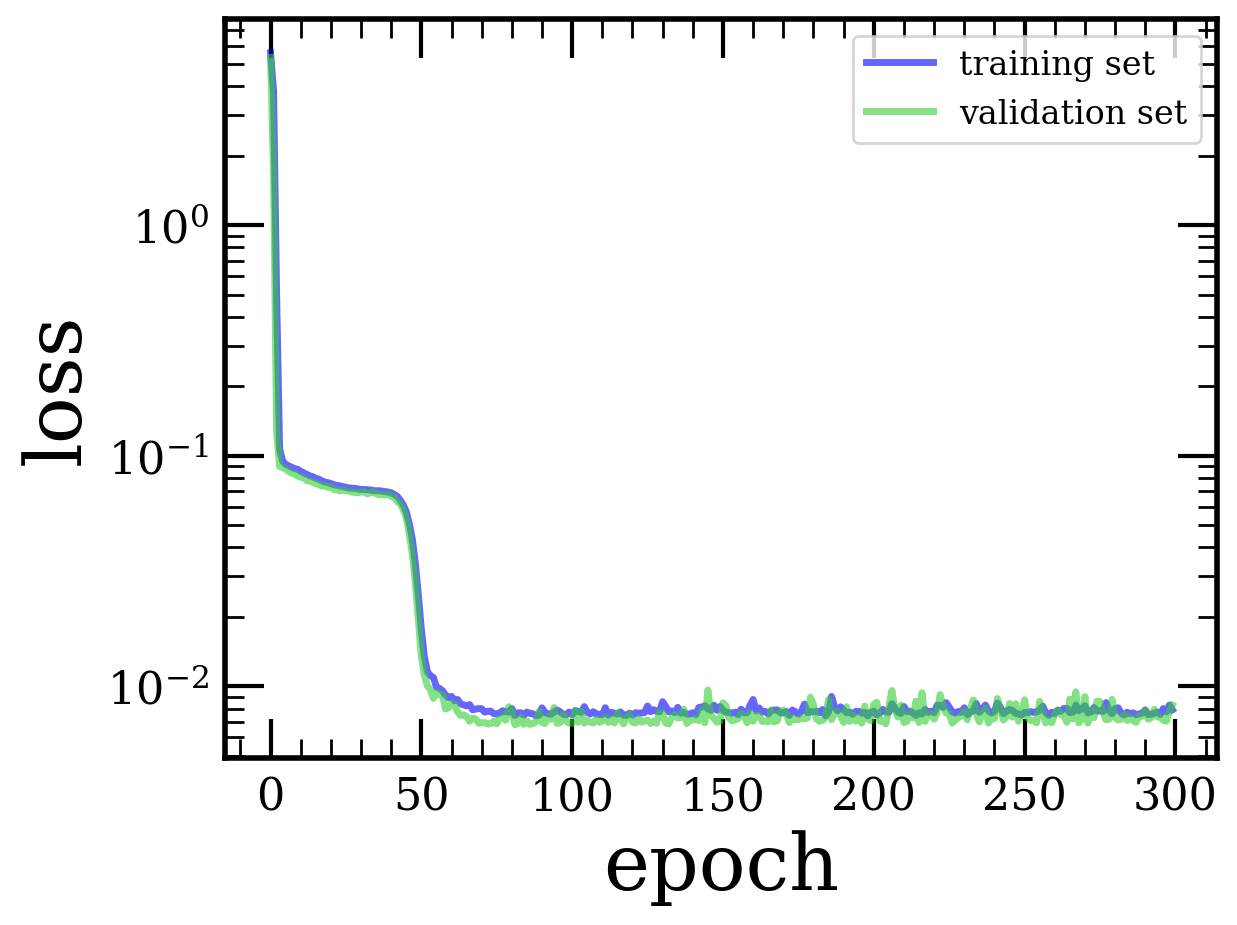

In [162]:
if run_moment:
    plt.plot(history.history['loss'], color='blue', label='training set', alpha=0.6)
    plt.plot(history.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
    plt.legend(fontsize=12)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.yscale('log')
    #plt.ylim(0, 0.005)

In [163]:
if run_moment:
    theta_train_pred = regression.predict(np.atleast_2d(Pk_train_scaled))
    theta_val_pred = regression.predict(np.atleast_2d(Pk_val_scaled))
    theta_test_pred = regression.predict(np.atleast_2d(Pk_test_scaled))

4/4 [==============================] - 0s 1ms/step


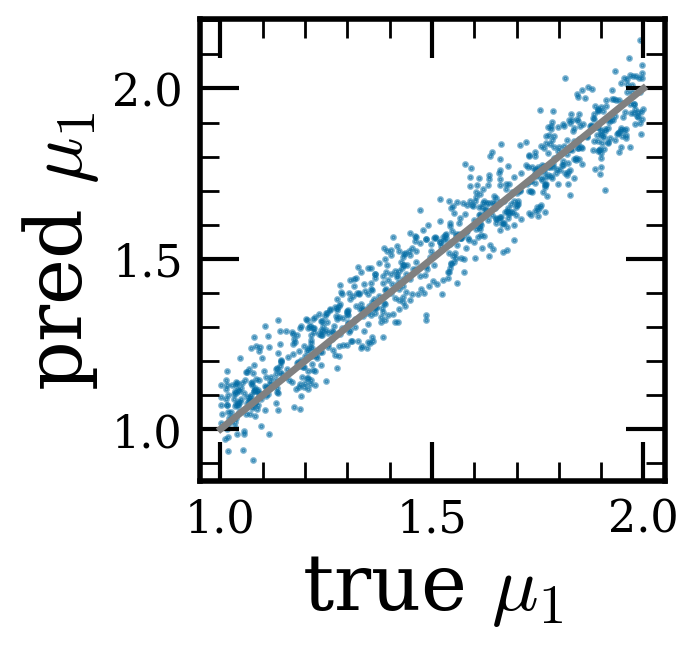

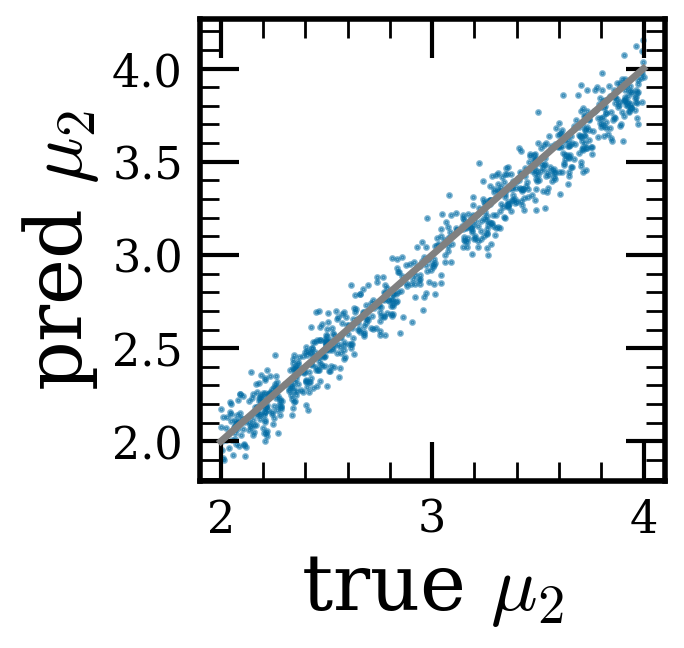

In [164]:
if run_moment:
    for pp in range(n_params):
        plt.figure(figsize=(3,3))
        plt.scatter(theta_train[:,pp], theta_train_pred[:,pp], s=2, alpha=0.5)
        plt.xlabel(rf'true {param_labels[pp]}')
        plt.ylabel(rf'pred {param_labels[pp]}')
        xx = np.linspace(np.min(theta_train[:,pp]), np.max(theta_train[:,pp]), 100)
        plt.plot(xx, xx, color='grey')
        #plt.xlim(-np.max(abs(delta_param)), np.max(abs(delta_param)))

-0.15696792088653014 0.17896123367604394
-0.10144220489674953 0.10505495328918836


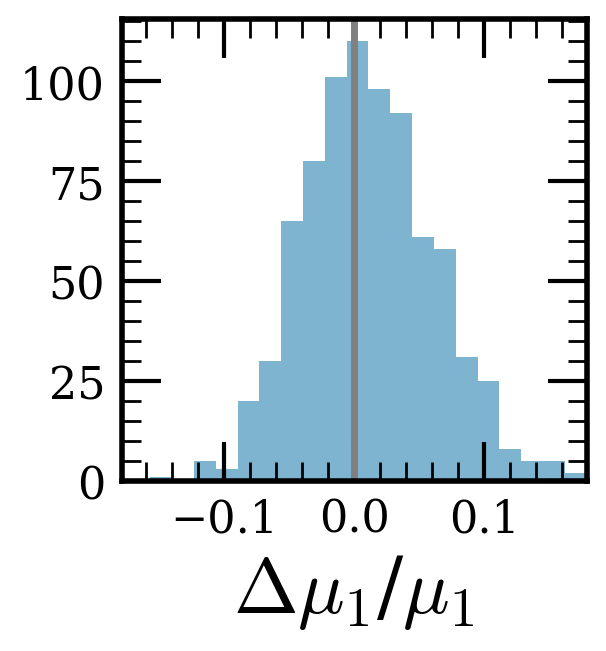

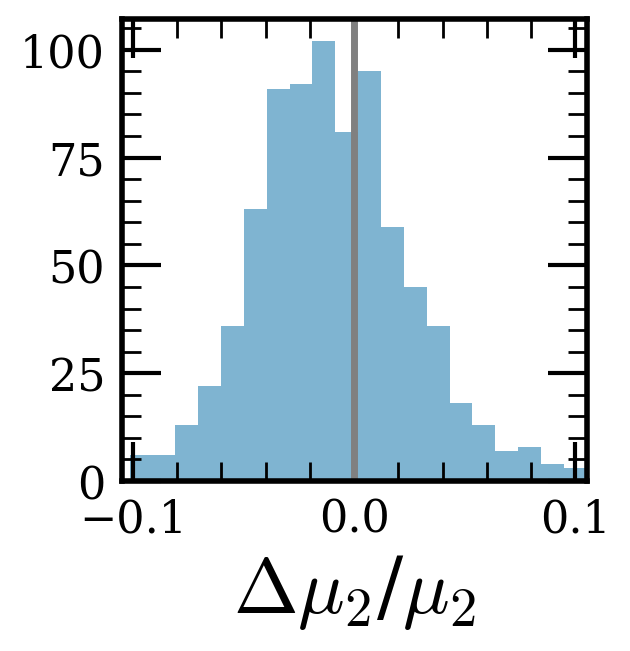

In [165]:
if run_moment:
    for pp in range(n_params):
        plt.figure(figsize=(3,3))
        delta_param = (theta_train_pred[:,pp] - theta_train[:,pp])/theta_train[:,pp]
        print(np.min(delta_param), np.max(delta_param))
        plt.hist(delta_param, bins=20, alpha=0.5)
        plt.xlabel(rf'$\Delta${param_labels[pp]}/{param_labels[pp]}')
        plt.axvline(0, color='grey')
        plt.xlim(-np.max(abs(delta_param)), np.max(abs(delta_param)))

Get means and residuals

In [166]:
if run_moment:
    cov_dict = {}

    training_covariances = []
    training_covariances_val = []
    training_covariances_test = []
    count = 0
    for i in range(n_params):
        for j in range(n_params):
            if j<i:
                cov_dict[(i,j)] = cov_dict[(j,i)]
                continue
            training_cov = ((theta_train[:,i]-theta_train_pred[:,i])* \
                            (theta_train[:,j]-theta_train_pred[:,j]))
            training_covariances.append(training_cov)
            
            training_cov_val = ((theta_val[:,i]-theta_val_pred[:,i])* \
                                (theta_val[:,j]-theta_val_pred[:,j]))
            training_covariances_val.append(training_cov_val)
            
            training_cov_test = ((theta_test[:,i]-theta_test_pred[:,i])* \
                                 (theta_test[:,j]-theta_test_pred[:,j]))
            training_covariances_test.append(training_cov_test)
            
            cov_dict[(i,j)] = count
            count += 1
            
    training_covariances = np.array(training_covariances).T
    training_covariances_val = np.array(training_covariances_val).T
    training_covariances_test = np.array(training_covariances_test).T

    n_covs = training_covariances.shape[1]

In [167]:
cov

[[0.005, 0.0], [0.0, 0.01]]

In [168]:
print(training_covariances_test[idx_test])
print(np.sqrt(training_covariances_test[idx_test]))

[0.01952803 0.02160241 0.02389714]
[0.13974272 0.14697758 0.15458701]


In [169]:
np.median(training_covariances, axis=0), np.std(training_covariances, axis=0)

(array([ 2.51517699e-03, -4.82290676e-05,  5.08954284e-03]),
 array([0.00664529, 0.00713797, 0.01435637]))

In [170]:
def compute_cov_predmean(theta, theta_pred):
    cov = np.empty((theta.shape[1], theta.shape[1]))
    n_samples = theta.shape[0]
    for pp_i in range(theta.shape[1]):
        for pp_j in range(theta.shape[1]):
            val = 0
            for i in range(n_samples):
                val += (theta[i][pp_i] - theta_pred[i][pp_i])*(theta[i][pp_j] - theta_pred[i][pp_j])
            cov[pp_i,pp_j] = val/n_samples
    return cov

def compute_cov_truemean(theta, bias=False):
    cov = np.empty((theta.shape[1], theta.shape[1]))
    theta_means = np.mean(theta, axis=0)
    n_samples = theta.shape[0]
    if bias:
        norm = n_samples
    else:
        norm = n_samples - 1
    for pp_i in range(theta.shape[1]):
        for pp_j in range(theta.shape[1]):
            val = 0
            for i in range(n_samples):
                val += (theta[i][pp_i] - theta_means[pp_i])*(theta[i][pp_j] - theta_means[pp_j])
            cov[pp_i,pp_j] = val/norm
    return cov

In [171]:
if run_moment:
    #model_instance = demo.simple_leaky(n_dim, n_covs, learning_rate=None)
    model_instance = neural_net(n_dim, n_covs, hidden_size=32, learning_rate=None)
    regression_var_unknown_mean = model_instance.model()

2
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_28 (Dense)            (None, 32)                96        
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 32)                1056      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                1056      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 32)                0 

In [172]:
if run_moment:
    history_var = regression_var_unknown_mean.fit(Pk_train_scaled,
                                            training_covariances,
                                            epochs=300, batch_size=32, shuffle=True,
                                            validation_data = (Pk_val_scaled,
                                                                training_covariances_val))

Epoch 1/300
25/25 [==============================] - 3s 27ms/step - loss: 1.0750e-04 - val_loss: 9.2126e-05
Epoch 2/300
25/25 [==============================] - 0s 16ms/step - loss: 1.0164e-04 - val_loss: 9.2803e-05
Epoch 3/300
25/25 [==============================] - 0s 9ms/step - loss: 1.0091e-04 - val_loss: 9.2991e-05
Epoch 4/300
25/25 [==============================] - 0s 2ms/step - loss: 1.0116e-04 - val_loss: 9.2194e-05
Epoch 5/300
25/25 [==============================] - 0s 3ms/step - loss: 1.0138e-04 - val_loss: 9.2571e-05
Epoch 6/300
25/25 [==============================] - 0s 5ms/step - loss: 1.0140e-04 - val_loss: 9.2955e-05
Epoch 7/300
25/25 [==============================] - 0s 15ms/step - loss: 1.0099e-04 - val_loss: 9.1627e-05
Epoch 8/300
25/25 [==============================] - 0s 5ms/step - loss: 1.0122e-04 - val_loss: 9.1037e-05
Epoch 9/300
25/25 [==============================] - 0s 14ms/step - loss: 1.0108e-04 - val_loss: 9.1748e-05
Epoch 10/300
25/25 [=============

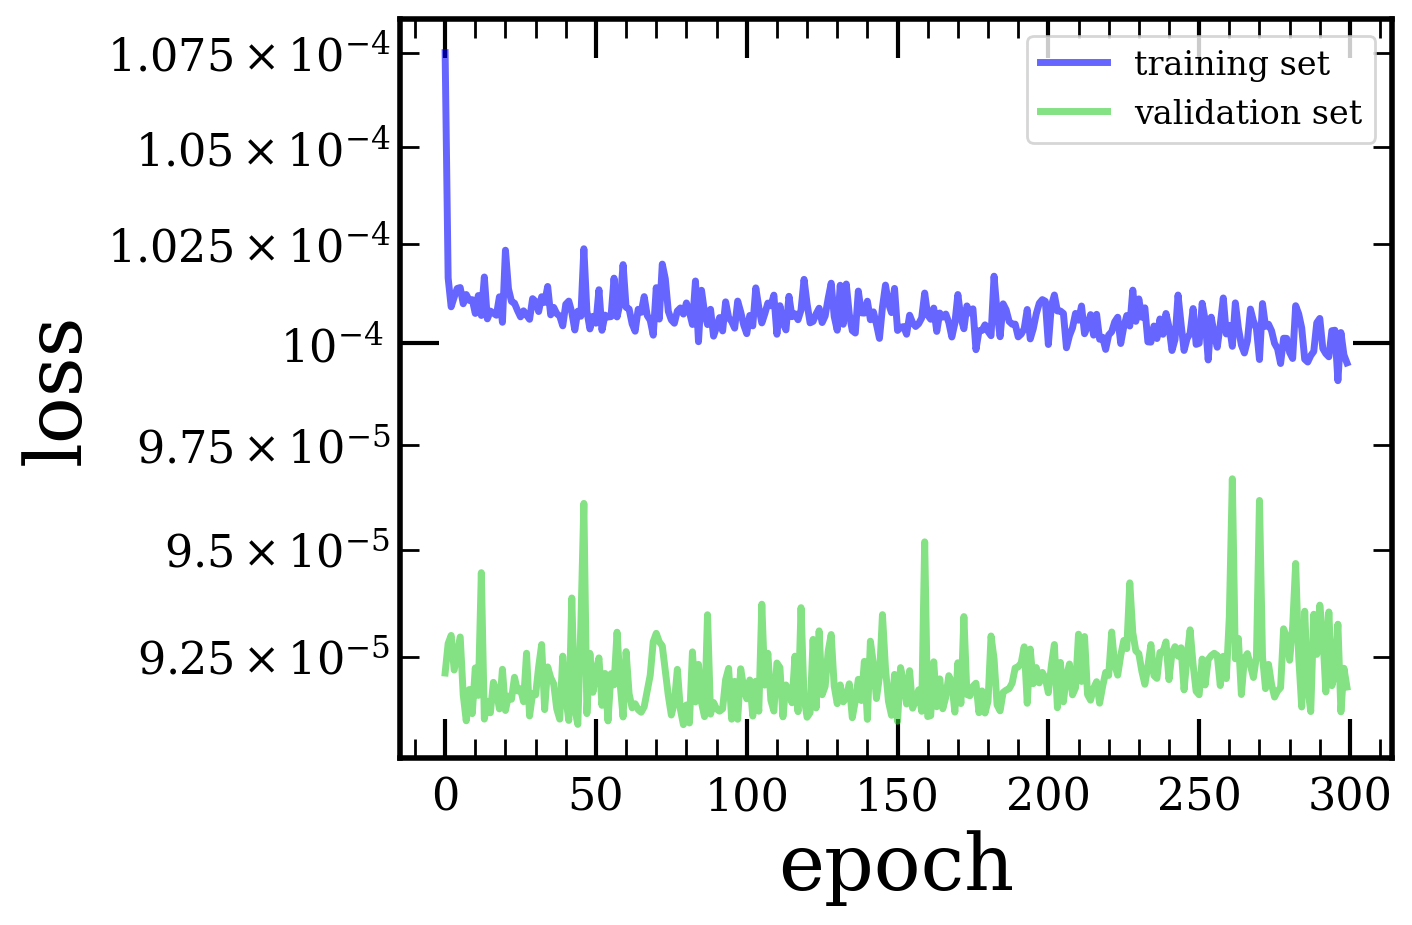

In [173]:
if run_moment:
    plt.plot(history_var.history['loss'], color='blue', label='training set', alpha=0.6)
    plt.plot(history_var.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
    plt.legend(fontsize=12)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.yscale('log')
    #plt.ylim(0, 0.005)

### SBI

In [174]:
# TODO deal with validation fraction being taken from training set
inference, posterior = sbi_tools.train_model(
    theta_train,
    Pk_train_scaled,
    prior=sbi_tools.get_prior(dict_bounds),
    training_batch_size=32,
    learning_rate=1e-3,
    validation_fraction=0.2
)

/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 Neural network successfully converged after 44 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 44
        Best validation performance: 2.0323
        -------------------------
        


### Explicit likelihood setup

In [175]:
# for emcee
n_burn = 1000
n_steps = 5000 # 50000
n_walkers = 4 * n_params

In [176]:
# for emcee
def log_prior(theta):
    for pp in range(len(param_names)):
       if (theta[pp] < dict_bounds[param_names[pp]][0]) or (theta[pp] >= dict_bounds[param_names[pp]][1]):
           return -np.inf
    return 0.0

# for dynesty
def prior_transform(u):

    u_transformed = []
    for pp in range(len(param_names)):
        width = dict_bounds[param_names[pp]][1] - dict_bounds[param_names[pp]][0]
        min_bound = dict_bounds[param_names[pp]][0]
        
        u_t = width*u[pp] + min_bound
        u_transformed.append(u_t)           

    return np.array(u_transformed)

In [177]:
global pk_data, cov_inv

def log_likelihood(theta):
    pk_model_unscaled = rng.multivariate_normal(theta, cov).T
    pk_model = scaler.scale(pk_model_unscaled)
    diff = pk_data-pk_model
    return -0.5*np.dot(diff,np.dot(cov_inv,diff))

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

### Test on a model from the test set (held-out data)

Moment network:

In [178]:
if run_moment:

    predicted_mean_obs_test = regression.predict(np.atleast_2d(pk_data))
    print(predicted_mean_obs_test)

    predicted_var_obs_test = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])
    moment_network_param_cov_test = np.empty((n_params, n_params))
    for i in range(n_params):
        for j in range(n_params):
            moment_network_param_cov_test[i,j] = predicted_var_obs_test[cov_dict[(i,j)]]
    print(moment_network_param_cov_test)

    moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
                                        moment_network_param_cov_test,int(1e6)),dtype=np.float32)
    gc.collect()

1/1 [==============================] - 0s 30ms/step
[[1.2334203 2.632065 ]]
1/1 [==============================] - 0s 67ms/step
[[0.00420937 0.0002649 ]
 [0.0002649  0.00824522]]


SBI

In [179]:
samples_sbi_test = sbi_tools.sample_posteriors_theta_test(
    posterior,
    np.atleast_2d(pk_data),
    dict_bounds,
    N_samples=10000
)[0]

0


Drawing 10000 posterior samples: 10065it [00:00, 62083.78it/s]                          


MCMC, Dynesty:

In [180]:
with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
    sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                         nlive=20, bound='single')
    sampler_test.run_nested(dlogz=0.001)

218it [00:14, 15.07it/s, +20 | bound: 2683 | nc: 1 | ncall: 81183 | eff(%):  0.293 | loglstar:   -inf < -0.000 <    inf | logz: -3.686 +/-  0.376 | dlogz:  0.000 >  0.001]


In [181]:
results_test = sampler_test.results
samples_dynesty_test = results_test.samples_equal()
print(samples_dynesty_test.shape)

(238, 2)


MCMC, emcee:

In [182]:
if run_emcee:
    rng = np.random.default_rng(seed=42)
    theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
                        for param_name in param_names] for _ in range(n_walkers)])

    start = time.time()
    if n_threads>1:
        with Pool(processes=n_threads) as pool:
            sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
            _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    else:
        sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
        _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    end = time.time()

    print(f"Time: {end-start} s ({(end-start)/60} min)")

    samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True, thin=1)
    gc.collect()

100%|██████████| 5000/5000 [00:04<00:00, 1018.87it/s]


Time: 4.915229558944702 s (0.08192049264907837 min)


### Plot contours

Is there a "true" covariance in this toy case i can compare to?!?

The cov i input is in the data space, not the parameter space...

In [183]:
def plot_contours(extents={}):

    c = chainconsumer.ChainConsumer()

    if run_moment:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(moment_network_samples_test, columns=param_names),
                    name='Moment Network', color='blue')
                    )

    # c.add_chain(chainconsumer.Chain(
    #             samples=pd.DataFrame(samples_sbi_test, columns=param_names),
    #             name='SBI', color='orange',
    #             smooth=1, bins=10)
    #             )

    if run_emcee:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(samples_emcee, columns=param_names),
                    name='MCMC (emcee)', color='purple', ls='--',
                    smooth=2, bins=10)
                    )

    c.add_chain(chainconsumer.Chain(
                samples=pd.DataFrame(samples_dynesty_test, columns=param_names),
                name='MCMC (Dynesty)', color='green', 
                smooth=2, bins=5)
                )

    c.set_plot_config(
        chainconsumer.PlotConfig(
            flip=True,
            labels=param_label_dict,
            contour_label_font_size=12,
            extents=extents,
        )
    )

    truth_loc = dict(zip(param_names, theta_test[idx_test]))
    c.add_truth(chainconsumer.Truth(location=truth_loc))

    fig = c.plotter.plot(figsize = (5,4) )
    if save_plots:
        plt.savefig(f'{plot_dir}/contours_test{idx_test}{tag_data}{tag_fit}.png')

In [184]:
np.sqrt(training_covariances_test[idx_test])

array([0.13974272, 0.14697758, 0.15458701])

In [185]:
np.sqrt(training_covariances)

/tmp/ipykernel_234014/278410798.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(training_covariances)


array([[0.00409723, 0.00741148, 0.01340663],
       [0.02800778,        nan, 0.19598489],
       [0.04184914, 0.04593105, 0.05041109],
       ...,
       [0.10399833, 0.06488697, 0.04048448],
       [0.02020971, 0.02386495, 0.02818131],
       [0.0232726 ,        nan, 0.00215276]])

In [186]:
np.median(np.sqrt(training_covariances_test[:,0]), axis=0)

0.0476902482815631

TODO understand nans!!!

In [187]:
cov_dict

{(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 2}

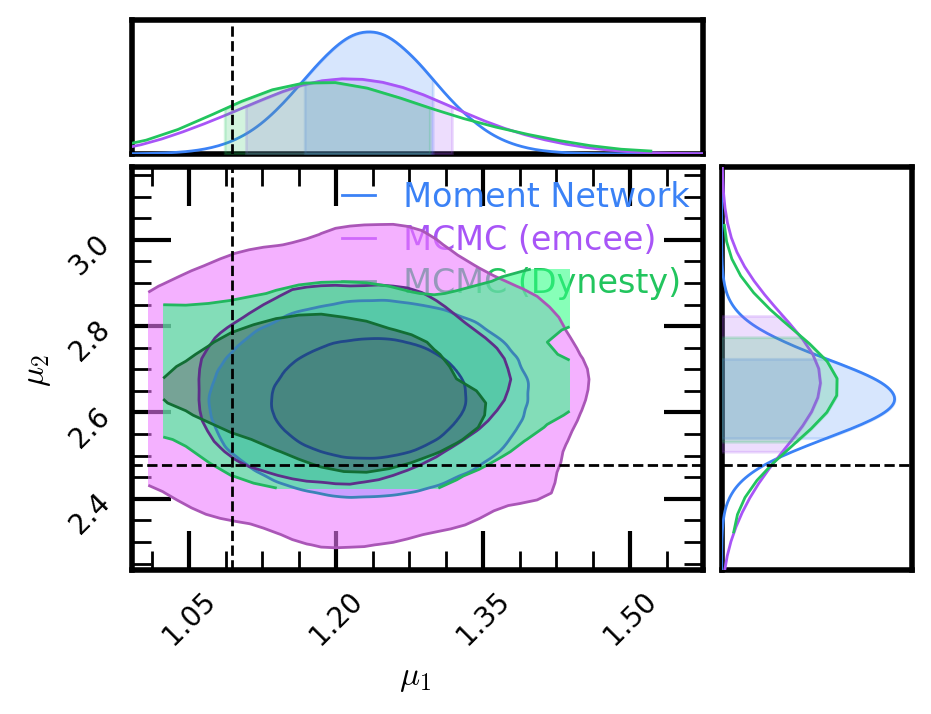

In [188]:
plot_contours()

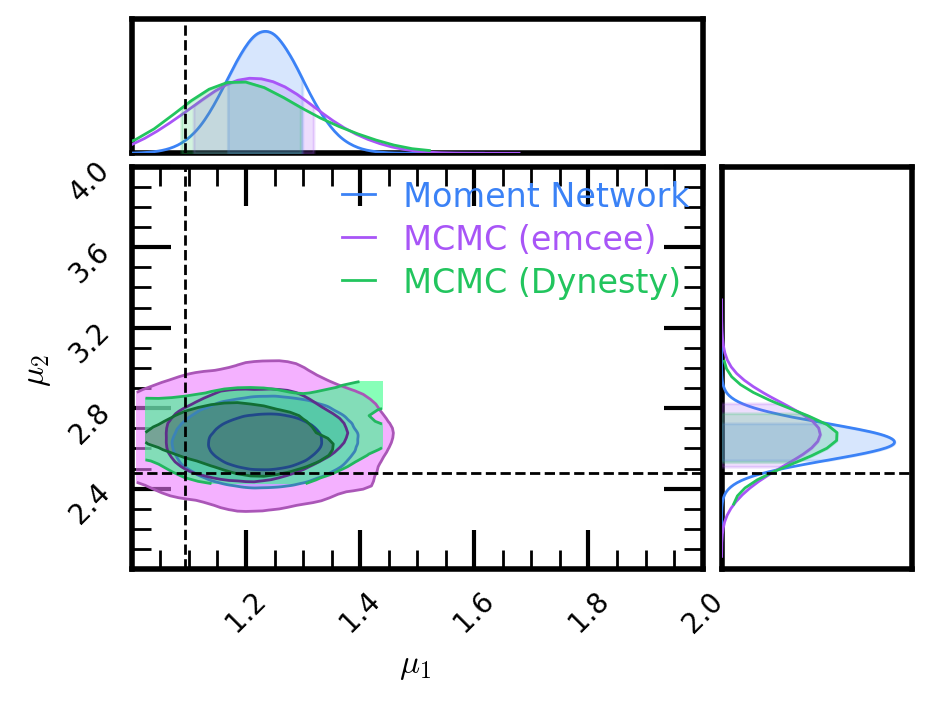

In [189]:
plot_contours(extents=dict_bounds)

### For all test data

In [190]:
sigmas_from_truth = []
theta_test_pred = regression.predict(Pk_test_scaled)
vars_test_pred = regression_var_unknown_mean.predict(Pk_test_scaled)
#print(theta_pred_test.shape, vars_pred_test.shape)

for i in range(Pk_test_scaled.shape[0]):
    pk_data_test = Pk_test_scaled[i]
    
    moment_network_param_cov_test = np.empty((n_params, n_params))
    for ii in range(n_params):
        for jj in range(n_params):
            moment_network_param_cov_test[ii,jj] = vars_test_pred[i][cov_dict[(ii,jj)]]
    
    # just doing for variances now, not covariance
    #print(theta_test_pred[i])Attending Conferences

    #print(theta_test[i])
    #print(moment_network_param_cov_test)
    err = np.sqrt(np.diag(moment_network_param_cov_test))
    #print(err)
    sigma_from_truth = (theta_test[i] - theta_test_pred[i])/err
    sigmas_from_truth.append(sigma_from_truth)
    #print(sigma_from_truth)
sigmas_from_truth = np.array(sigmas_from_truth)

4/4 [==============================] - 0s 1ms/step


In [191]:
idx_nan = (vars_test_pred[:,0] < 0) | (vars_test_pred[:,2] < 0)
print(np.sum(idx_nan))

0


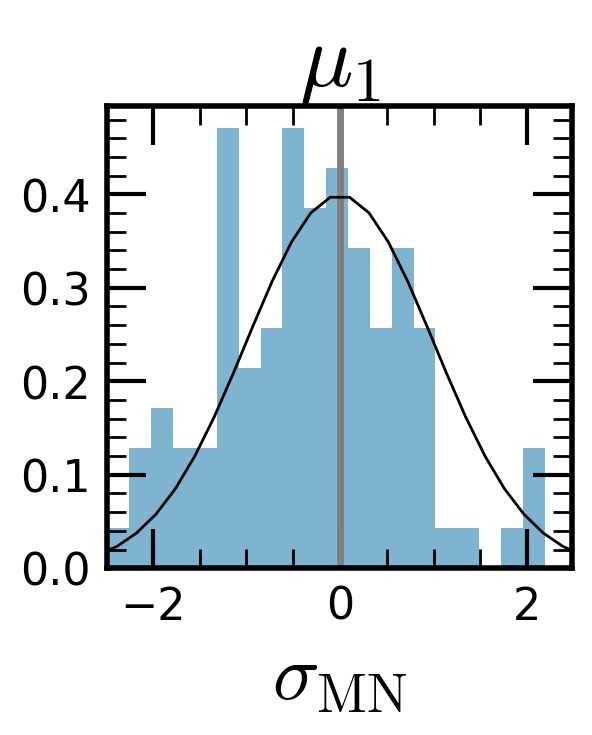

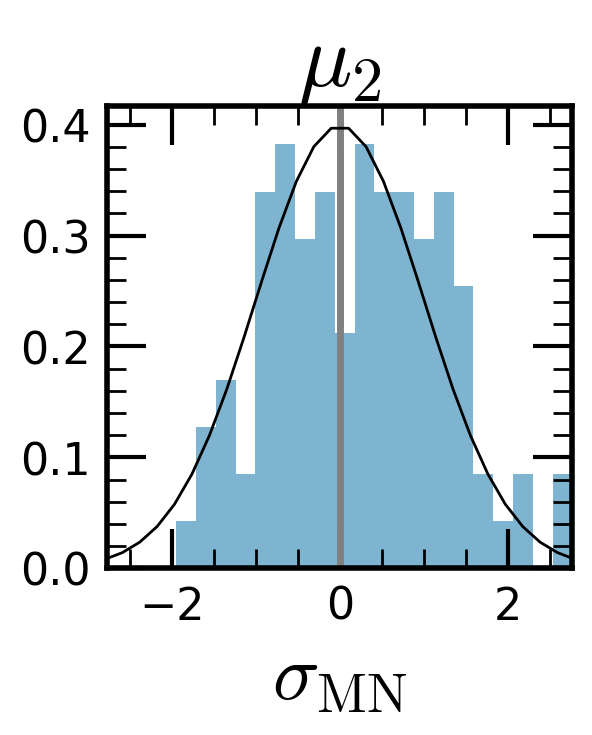

In [192]:
x_normal = np.linspace(-3, 3, 30)
mean, variance = 0, 1
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
for pp in range(n_params):
    plt.figure(figsize=(3,3))
    plt.title(rf'{param_labels[pp]}')
    plt.hist(sigmas_from_truth[:,pp], bins=20, alpha=0.5, density=True)
    plt.xlabel(r'$\sigma_\text{MN}$')
    plt.axvline(0, color='grey')
    plt.xlim(-np.max(abs(sigmas_from_truth[:,pp])[~idx_nan]), np.max(abs(sigmas_from_truth[:,pp])[~idx_nan]))
    
    plt.plot(x_normal, y_normal, color='black', lw=1)

### Try another test model

In [193]:
idx_test = 8
pk_data = Pk_test_scaled[idx_test]

Moment network:

In [194]:
predicted_mean_obs_test = regression.predict(np.atleast_2d(pk_data))
predicted_var_obs_test = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])

moment_network_param_cov_test = np.empty((n_params, n_params))

for i in range(n_params):
    for j in range(n_params):
        moment_network_param_cov_test[i,j] = predicted_var_obs_test[cov_dict[(i,j)]]
print(moment_network_param_cov_test)

1/1 [==============================] - 0s 18ms/step
[[0.00242429 0.00070764]
 [0.00070764 0.00629915]]


In [195]:
moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
                                  moment_network_param_cov_test,int(1e6)),dtype=np.float32)
gc.collect()

38673

MCMC, Dynesty:

In [196]:
with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
    sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                         nlive=20, bound='single')
    sampler_test.run_nested(dlogz=0.01)

189it [00:01, 121.43it/s, +20 | bound: 260 | nc: 1 | ncall: 8456 | eff(%):  2.477 | loglstar:   -inf < -0.000 <    inf | logz: -4.582 +/-  0.412 | dlogz:  0.000 >  0.010]


In [197]:
results_test = sampler_test.results
samples_dynesty_test = results_test.samples_equal()
print(samples_dynesty_test.shape)

(209, 2)


MCMC, emcee:

In [198]:
if run_emcee:
    rng = np.random.default_rng(seed=42)
    theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
                        for param_name in param_names] for _ in range(n_walkers)])

    start = time.time()
    if n_threads>1:
        with Pool(processes=n_threads) as pool:
            sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
            _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    else:
        sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
        _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    end = time.time()

    print(f"Time: {end-start} s ({(end-start)/60} min)")

    samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True, thin=1)
    gc.collect()

100%|██████████| 5000/5000 [00:04<00:00, 1038.57it/s]

Time: 4.821379661560059 s (0.08035632769266764 min)


### Plot contours

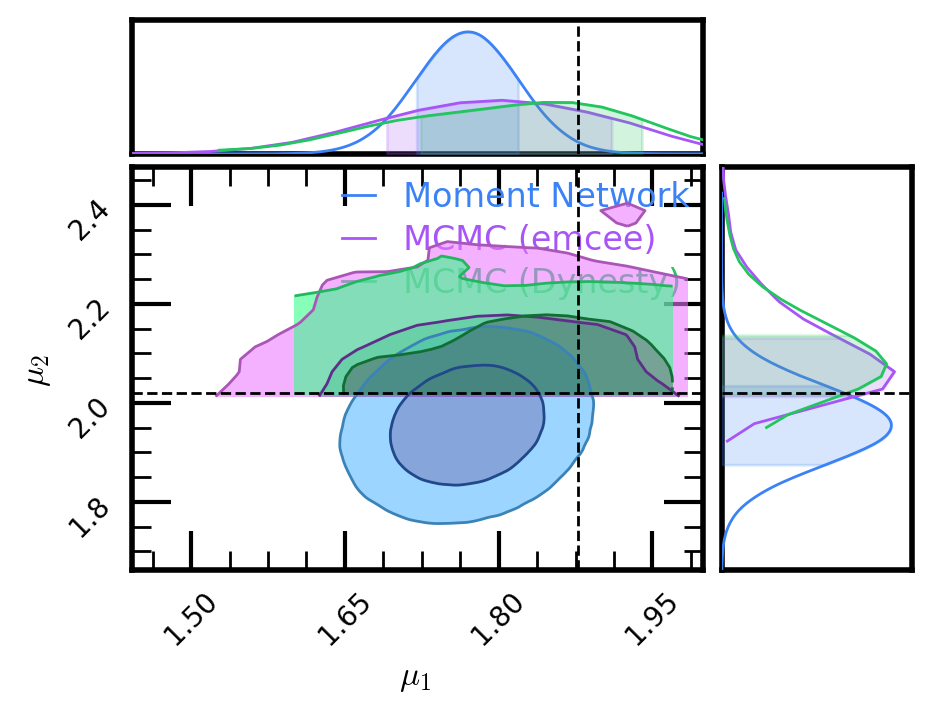

In [199]:
c = chainconsumer.ChainConsumer()

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(moment_network_samples_test, columns=param_names),
            name='Moment Network', color='blue')
            )

if run_emcee:
    c.add_chain(chainconsumer.Chain(
                samples=pd.DataFrame(samples_emcee, columns=param_names),
                name='MCMC (emcee)', color='purple', ls='--',
                smooth=1, bins=10)
                )

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(samples_dynesty_test, columns=param_names),
            name='MCMC (Dynesty)', color='green', 
            smooth=2, bins=5)
            )

c.set_plot_config(
    chainconsumer.PlotConfig(
        flip=True,
        labels=param_label_dict,
        contour_label_font_size=12,
        #extents=dict_bounds,
    )
)

truth_loc = dict(zip(param_names, theta_test[idx_test]))
c.add_truth(chainconsumer.Truth(location=truth_loc))

fig = c.plotter.plot(figsize = (5,4) )
if save_plots:
    plt.savefig(f'{plot_dir}/contours_test{idx_test}{tag_emuPk}{tag_fit}.png')